# Unet Pipeline

0. Preprocessing
    * Ground truth masks are prepared by first eroding them per mask creating non overlapping masks
    * Distances to the 2 closest objects are calculated creating the distance map that is used for weighing
    * Ground truth masks for overlapping contours (DSB-2018 winners approach)
    * Dropped small masks on the edges
    * Dilated small objectcs to increase the signal (no experimental results yet)

1. We load training and validation data in batches:
    * using `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` makes it easy and clean (see `loaders.py` )

    * only some basic augmentations (due to speed constraints) from the `imgaug` package are be applied to images (see `augmentations.py` )
    * Image resize was replaced by Random crop

2. We train a unet architecture with the encoder taken from resnet34 for the multiclass problem. 
    * The implementation can be explored in `unet_models` proposed and implemented by Alexander Buslaev https://www.linkedin.com/in/al-buslaev/

    * We implemented loss weighing, where the closer the pixel is to the object the higher the weight is. It is based on the following paper https://arxiv.org/pdf/1505.04597.pdf
    * The parameters are specified in `neptune.yaml`
    * We added deeper resnet-based encoders( 34,101,152 flavours) (no experimental results yet)
    * We added loss weighing by object size to the cross entropy loss (no experimental results yet)
    * We added Dice loss to weigh it with size and distance weighted cross entropy to clean up masks (no experimental results yet)
    * We run inference on padded crops with replication of the last pixel (reflection pad didn't work to well)

3. Following postprocessing is applied to the output:
    * images are cropped to `300x300` 
    * CRF on masks and original images is performed to smoothen up the results. Because this approach is very slow we haven't used it in our current predictions. We will experiment later, having all other ideas in place.
    * instances of the same class are labeled 
    * for each instance the dilation is performed with the same selem that was used for eroding the target masks in the first place 
    * for each building area the mean probability is calculated
    
The entire pipeline is defined in the `pipelines.py`. You can import it and visualize it in the notebook by running:

neptune: Executing in Offline Mode.
neptune: Executing in Offline Mode.


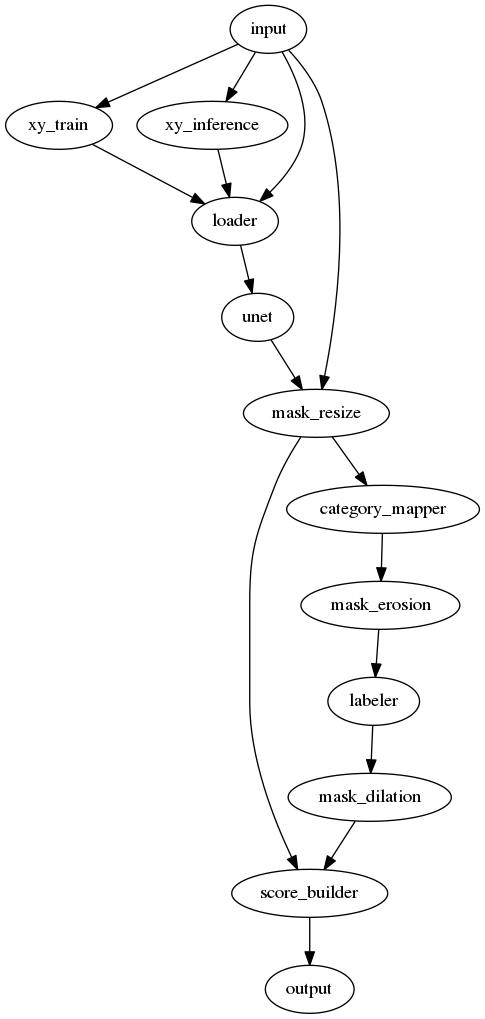

In [22]:
from pipelines import unet_weighted_padded
import pipeline_config as cfg

unet_weighted_padded(cfg.SOLUTION_CONFIG, train_mode=True)

One can easily extend this pipeline by adding new steps to it.
You just need to implement your Transformer

```python
from steps.base import BaseTransformer

class MyTransformer(BaseTransformer):
    def __init__(self, example_attribute_1, example_attribute_2):
        self.example_attribute_1 = example_attribute_1
        self.example_attribute_2 = example_attribute_2
        
    def fit(self, argument_1, argument_2, **kwargs):
        """ Do trainable logic here
        """
        return self
        
    def transform(self, argument_1, argument_2, **kwargs): 
        """ Apply transform based on trainable logic (or not) here
        """
        return {'output_name_1': output_1,
                'output_name_2': output_2
               }
    def save(self, filepath):
        """ Saving logic goes here
        """
        pass
    
    def load(self, filepath):
        """ Loading logic goes here
        """
        return self
           
```

Check the examples of using steps here: https://github.com/minerva-ml /steps/tree/dev/examples 

or in other `open-solution-...` projects on https://github.com/minerva-ml .